# thermoNETs Use in Orbit Propagation

The objective of this notebook is to investigate how thermoNETs can be used within orbital propagation software to entirely replace thermospheric density models such as NRLMSISE-00 and JB-08. We will here discuss both the accuracy and speedup of this neural representations.

Let's start by deriving the equations of motion of a satellite in low-Earth orbit, but first, the needed imports...

In [3]:
import sys
sys.path.append('../')
import numpy as np
import thermonets as tn
import datetime
import heyoka as hk
import torch
import pickle
import time
from nrlmsise00 import msise_flat
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

The EOP file 'finals2000A.all' in /Users/ga00693/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in /Users/ga00693/src/iers/ is already the latest.


## 1 - Equations of Motion

We assume that the Earth is in a orbit around the Earth, and we assume that its motion is influenced only by Earth central gravity and the drag due to the atmosphere.

We therefore write the equations of motion as:

\begin{equation}
\dfrac{d\pmb{\ddot{r}}}{dt} = -\mu\dfrac{\pmb{r}}{{|\pmb{r}|^3}} - \dfrac{1}{2} \dfrac{C_D A}{m}\rho |\pmb{v}_r| \pmb{v}_r\text{,}
\end{equation}

where $\mu$ is the gravitational parameter of the Earth, $C_D$ is the drag coefficient of the satellite, $A$ its area, $m$ its mass, $\pmb{v}_r$ is the vector of the relative velocity of the satellite w.r.t. the air.
```{warning}

**Important**: in this notebook we ignore both the fact that the Earth is not a perfect sphere and we also neglect the wind term for the computation of the relative velocity. Furthermore, we also ignore precession and nutation effects.

```

For [WSG-84](https://earth-info.nga.mil/index.php?dir=wgs84&action=wgs84), we have that the Earth gravitational parameter is: $\mu=3.986004418 \times 10^{14}\ m^3/s^2$ and the Earth rotation rate is: $\omega_z=7.292115 \ rad/s$

### The thermospheric drag term

As shown above, the perturbing acceleration due to the thermospheric drag can be written as:

\begin{equation}
\pmb{a}_D=-\dfrac{1}{2} \dfrac{C_D A}{m}\rho |\pmb{v}_r| \pmb{v}_r\text{,}
\end{equation}

where $\rho$ is the thermospheric density value at the spacecraft location. The relative velocity can be written as the velocity of the spacecraft, minus the air velocity (again, we ignore the wind in this notebook):

\begin{equation}
\pmb{v}_r=\dfrac{d\pmb{r}}{dt}-\pmb{\omega}\times \pmb{r}=\bigg[\dfrac{dx}{dt}+\omega_z y, \ \dfrac{dy}{dt}-\omega_z x, \ \dfrac{dz}{dt}\bigg]^T\text{,}
\end{equation}

where $\pmb{\omega}=[0,0,\omega_z]^T$ is the rotation vector of the Earth. 

The thermospheric density value depends on several factors ranging from the spacecraft location and the local time, to seasonality, solar activity, and space weather. To model this, we use both the original NRLMSISE-00 model, as well as its neural network substitute (developed in `nrlmsise00_train.ipynb` and analyzed in `nrlmsise00_analysis.ipynb`). 

Let's now start by defining a few useful constants:

In [4]:
#First we need to set some variables useful for integration:
mu = 3.986004407799724e14                  #Earth gravitational parameter SI
r_earth = 6378.1363*1e3                    #Earth radius SI
initial_h=280.*1e3                         #Satellite's initial altitude SI
mass=200                                   #mass of the satellite SI
area=2                                     #drag cross-sectional area of the satellite in SI
cd=2.2                                     #drag coefficient [-]
bc = mass/(cd*area)                        #ballistic coefficient in SI
omega_e = 7.2921150e-5                     #Earth rotation rate SI
date0 = datetime.datetime(2015,3,4,12,0,0) #initial absolute time for the propagation
date0_mjd = tn.mjd(date0)
#we extract the spaceweather indices for the date of the integration
ap,f107,f107a = tn.get_nrlmsise00_spaceweather_indices(date0)

#we assume a circular orbit at first
initial_state=[r_earth+initial_h,0.,0., 0., np.sqrt(mu/(r_earth+initial_h)),0.]
t_span=(0.,60.*60*10.) #10 hours propagation


Now, we can perform the numerical integration:

* first, we integrate the equations of motion using `scipy` as numerical integrator, and `NRLMSISE-00` as thermospheric density model

* then, we leverage the differentiability of the neural network model and we perform the same integration with `heyoka` as numerical integrator, and `thermoNET` as thermospheric density model


## 2 - Scipy + NRLMSISE-00:

In [9]:
def dxdt(t, state, mu, f107A, f107, ap, bc, date0, omega_e):
    x,y,z,vx,vy,vz=state
    R=tn.earth_rotation_matrix(tn.mjd(date0+datetime.timedelta(seconds=t)))
    xyz_ecef=np.matmul(R,state[:3])
    r=np.sqrt(x**2+y**2+z**2)
    altitude,lat,long=tn.cart2geo(xyz_ecef[0],xyz_ecef[1],xyz_ecef[2])
    #nrlmsise-00 density (takes: datetime, altitude [km], latitude [deg], longitude [deg], f107, f107A, ap)
    rho=msise_flat(time=date0+datetime.timedelta(seconds=t), alt=altitude/1e3, lat=np.rad2deg(lat), lon=np.rad2deg(long), f107a=f107A, f107=f107, ap=ap)[5]*1e3
    vrel_x=vx+omega_e*y
    vrel_y=vy-omega_e*x
    adrag_x=-1/2*rho*np.sqrt(vrel_x**2+vrel_y**2+vz**2)*vx/bc
    adrag_y=-1/2*rho*np.sqrt(vrel_x**2+vrel_y**2+vz**2)*vy/bc
    adrag_z=-1/2*rho*np.sqrt(vrel_x**2+vrel_y**2+vz**2)*vz/bc
    ax=-mu*x/r**3+adrag_x
    ay=-mu*y/r**3+adrag_y
    az=-mu*z/r**3+adrag_z
    return np.array([vx,vy,vz,ax,ay,az])

In [10]:
sol = solve_ivp(dxdt, 
                t_span, 
                initial_state, 
                args=(mu, f107a, f107, ap, bc, date0, omega_e), 
                method='DOP853',
                rtol=1e-13,
                atol=1e-14)

## 3 - Heyoka + thermoNET

We have constructed a differentiable thermospheric density model (owing to the differentiability of neural networks). Hence, we can directly combine this with a Taylor propagator (i.e., `heyoka`).

### thermoNET construction

we first build the differentiable atmospheric model:

Let's now first retrieve one of the trained thermoNET density model (we here use the one trained on NRLMSISE-00, but the same can be done for the one trained on JB-08). 

Here we first directly load the flattened weights compatible with `heyoka` feed-forward neural network factory. For the interested reader, we wrote a [tutorial](https://bluescarni.github.io/heyoka.py/notebooks/torch_and_heyoka.html) on how to convert the `torch` weights & biases into this format. 

In [11]:
#we load the flattened weights and parameters of the neural network:
flattened_nw=np.loadtxt('nrlmsise00_flattened_nw_10_32_32_2.60.txt')

We now need to prepare all the inputs for the neural network. First, let us introduce the Cartesian variables:

In [12]:
#we first instantiate the state variables as heyoka variables:
x,y,z,vx,vy,vz=hk.make_vars("x","y","z","vx","vy","vz")

We write the numerical integrator in an inertial J2000 reference frame, with Cartesian coordinates. Hence, we need two steps:
* Step 1: rotate from J2000 to ECEF reference frame (we here ignore nutation and precession effects). For this, we use the [Earth Rotation Angle (ERA)](https://en.wikipedia.org/wiki/Sidereal_time#ERA)
* Step 2: convert from ECEF cartesian coordinates to geodetic latitude, longitude and altitude (we use the iterations from: "Physical Geodesy" by Heiskanen and Moritz, 1967 - implemented in `tn.cart2geo`)

Step 1 - Earth Rotation Angle

In [13]:
#we construct the Earth rotation matrix:
R=tn.earth_rotation_matrix(date0_mjd+hk.time/86400.,symbolic=True)
#we transform x,y,z into the ECEF frame:
xyz_ecef=np.matmul(R,[x,y,z])

Step 2 - from ECEF to Geodetic coordinates

In [14]:
altitude,lat,lon=tn.cart2geo(xyz_ecef[0],xyz_ecef[1],xyz_ecef[2],symbolic=True)

We can now construct all the normalized inputs needed for the thermoNET model of NRLMSISE-00:

In [15]:
#first latitude and longitude
sin_lon=hk.sin(lon)
cos_lon=hk.cos(lon)
lat_n=tn.normalize_min_max(lat,-np.pi/2,np.pi/2)
# This is the date we assume to start our integration at
offset=date0.second+date0.minute*60.+date0.hour*3600.
#seconds in the day
sec_in_day_n=(hk.time+offset)/86400.*2*np.pi
sin_sec_in_day=hk.sin(sec_in_day_n)
cos_sec_in_day=hk.cos(sec_in_day_n)
#day of the year
doy=date0.timetuple().tm_yday+hk.time/86400.
sin_doy = hk.sin(2*np.pi*doy/365.25)
cos_doy = hk.cos(2*np.pi*doy/365.25)

f107_n=tn.normalize_min_max(f107, 60., 266.)
f107a_n=tn.normalize_min_max(f107a, 60., 170.)
ap_n=tn.normalize_min_max(ap, 0., 110.)


We load the global fit:

In [16]:
with open('../global_fits/global_fit_nrlmsise00_180.0-1000.0-4.txt','rb') as f:
    best_global_fit=pickle.load(f)

we can now construct a symbolic expression for the thermoNET density. This takes x,y,z Cartesian coordinates in the J2000 frame, and the time from the start of the integration in seconds, and returns the thermospheric density value 

In [17]:
#we now construct the neural network in heyoka:
model_heyoka=hk.model.ffnn(inputs=[sin_lon,cos_lon,lat_n,sin_sec_in_day, cos_sec_in_day, sin_doy, cos_doy, hk.expression(f107_n), hk.expression(f107a_n), hk.expression(ap_n)],
                           nn_hidden=[32,32], 
                           n_out=12, 
                           activations=[hk.tanh,hk.tanh,hk.tanh], 
                           nn_wb=flattened_nw)

#and use this to construct the density:
params=[best_global_fit[i]*(1+model_heyoka[i]) for i in range(12)]
density_nn = tn.rho_approximation(altitude/1e3,params,backend='heyoka')
print(density_nn)

((exp(((0.0054930843422492867 + (0.0054930843422492867 * tanh(((0.015341942198574543 * tanh(((0.0030276232864707708 * tanh(((0.17684663832187653 * cos((1.0837527018543844 + (1.9910212776572320e-07 * t)))) + (0.28599441051483154 * cos(atan2(((x * sin((34915.342025321341 + (7.2921151467069791e-05 * t)))) + (y * cos((34915.342025321341 + (7.2921151467069791e-05 * t))))), ((x * cos((34915.342025321341 + (7.2921151467069791e-05 * t)))) - (y * sin((34915.342025321341 + (7.2921151467069791e-05 * t)))))))) + (1.0323368310928345 * sin(atan2(((x * sin((34915.342025321341 + (7.2921151467069791e-05 * t)))) + (y * cos((34915.342025321341 + (7.2921151467069791e-05 * t))))), ((x * cos((34915.342025321341 + (7.2921151467069791e-05 * t)))) - (y * sin((34915.342025321341 + (7.2921151467069791e-05 * t)))))))) + (1.0680074691772461 * sin((3.1415926535897931 + (7.2722052166430395e-05 * t)))) - 0.22564441500608101 - (0.43528041243553162 * cos((3.1415926535897931 + (7.2722052166430395e-05 * t)))) - (0.089860

### Numerical Integration with Differentiable Atmosphere
Let us know construct the equations of motion and integrate the dynamics:

In [18]:
akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

vrel_x=vx+omega_e*y
vrel_y=vy-omega_e*x
adragx=-1/2*density_nn*vx*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
adragy=-1/2*density_nn*vy*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
adragz=-1/2*density_nn*vz*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
dyn_drag=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]


In [19]:
start_time = time.time()
ta=hk.taylor_adaptive(
    dyn_drag,
    initial_state,
    compact_mode=True,
    tol=1e-14,
)
print(f'{time.time()-start_time} to build the integrator')

0.6335098743438721 to build the integrator


we now perform the integration

In [20]:
ta.state[:] = initial_state
ta.time=0.
sol_heyoka_nn=ta.propagate_grid(sol.t)

In [21]:
ta.state[:] = initial_state
ta.time=0.
sol_heyoka_fit_global=ta.propagate_grid(sol.t)
res_x_heyoka_fit_global=sol_heyoka_fit_global[-1][:,0]
res_y_heyoka_fit_global=sol_heyoka_fit_global[-1][:,1]
res_z_heyoka_fit_global=sol_heyoka_fit_global[-1][:,2]
res_vx_heyoka_fit_global=sol_heyoka_fit_global[-1][:,3]
res_vy_heyoka_fit_global=sol_heyoka_fit_global[-1][:,4]
res_vz_heyoka_fit_global=sol_heyoka_fit_global[-1][:,5]

## 4 - Results Comparison 

### Performance

Scipy + NRLMSISE-00 integration time:

In [22]:
%%timeit
sol = solve_ivp(dxdt, 
                t_span, 
                initial_state, 
                args=(mu, f107a, f107, ap, bc, date0, omega_e), 
                method='DOP853',
                rtol=1e-13,
                atol=1e-14)

634 ms ± 5.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Heyoka + NN integration time:

In [23]:
%%timeit
ta.state[:] = initial_state
ta.time=0.
sol_heyoka_nn=ta.propagate_grid(sol.t)

6.56 ms ± 55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


.. the Taylor propagator with the differentiable atmosphere is 100x faster!

### Accuracy Comparison

While `thermoNET` very accurately emulates the `NRLMSISE-00` model, it will always have an albeit small error in the density reconstruction. This error, inside a numerical integration scheme will propagate and grow. Hence, it is improtant to investigate how well the trajectory can be reconstructed with the thermoNET model.

For this comparison, we analyze three different models:
* NRLMSISE-00
* thermoNET
* the global fit

In [24]:
#global fit results:
density_fit_global = tn.rho_approximation(altitude/1e3, best_global_fit,backend='heyoka')
akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

vrel_x=vx+omega_e*y
vrel_y=vy-omega_e*x
adragx=-1/2*density_fit_global*vx*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
adragy=-1/2*density_fit_global*vy*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
adragz=-1/2*density_fit_global*vz*hk.sqrt(vrel_x**2+vrel_y**2+vz**2)/bc
dyn_drag_fit_global=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]

ta_global_fit=hk.taylor_adaptive(
    dyn_drag_fit_global,
    initial_state,
    compact_mode=True,
    tol=1e-14,
)

Let's now plot a few trajectories. We here investigate different cases in the VLEO regimes as initial states:
* 200 km equatorial orbit
* 200 km highly inclined (i=85deg) orbit
* 300 km equatorial orbit
* 300 km highly inclined (i=85deg) orbit
* 400 km equatorial orbit
* 400 km highly inclined (i=85deg) orbit
* 400 km highly inclined (i=85deg) and elliptical orbit (e=0.1)

We integrate each of these for 10 hours.

In [30]:
initial_states=[]
#250 km equatorial:
initial_states.append([6628136.3, 0.0, 0.0, 0.0, 7754.845896946365, 0.0])
#250 km highly inclined:
initial_states.append([6628136.3, 0.0, 0.0, 0.0, 675.8793540419897, 7725.336367056496])
#300 km equatorial:
initial_states.append([6678136.3, 0.0, 0.0, 0.0, 7725.760627097719, 0.0])
#300 km highly inclined:
initial_states.append([6678136.3, 0.0, 0.0, 0.0, 673.3444057453148, 7696.361775440707])
#400 km equatorial:
initial_states.append([6778136.3, 0.0, 0.0, 0.0, 7668.558561573406, 0.0])
#400 km highly inclined:
initial_states.append([6778136.3, 0.0, 0.0, 0.0, 668.3589172378431, 7639.3773810454895])


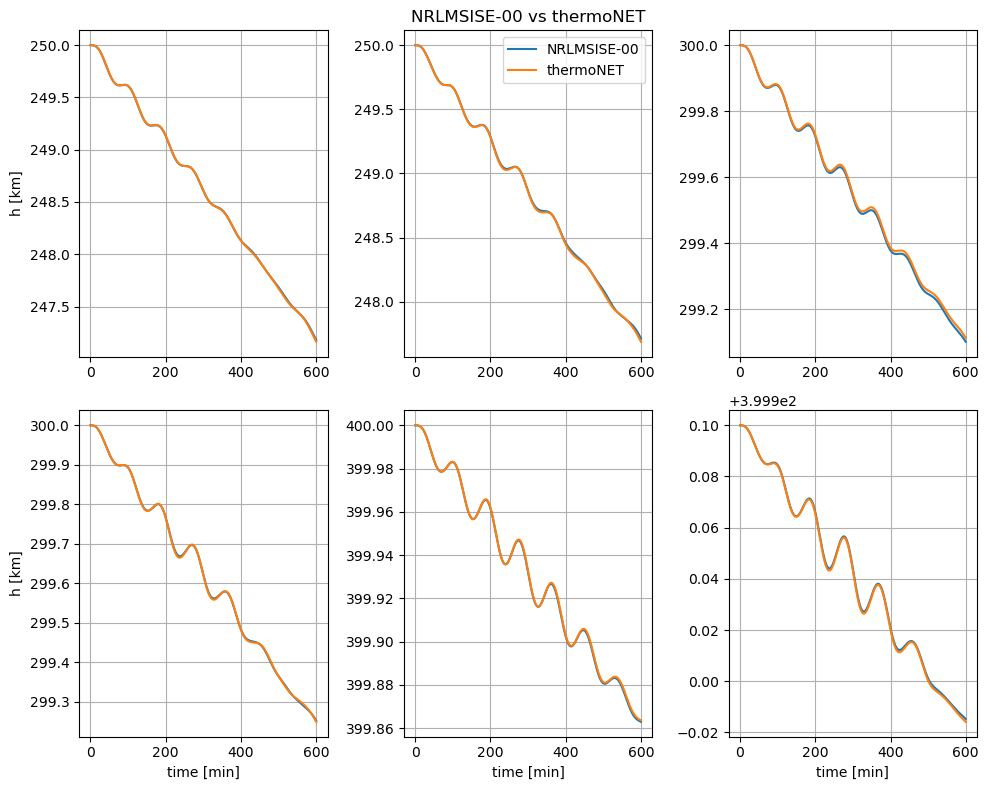

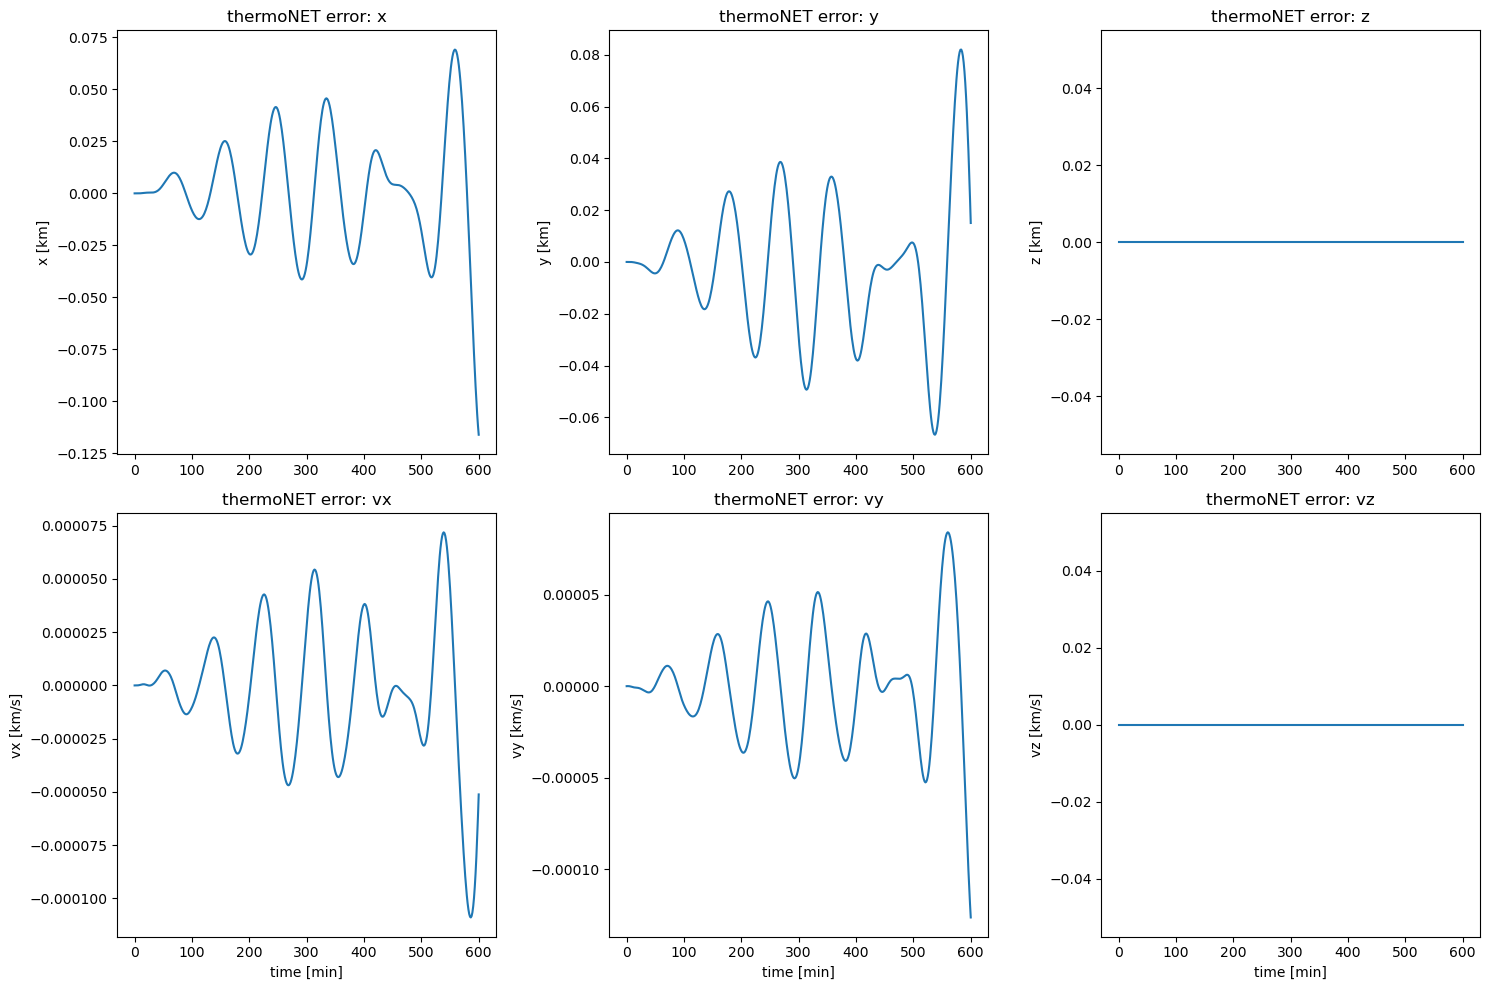

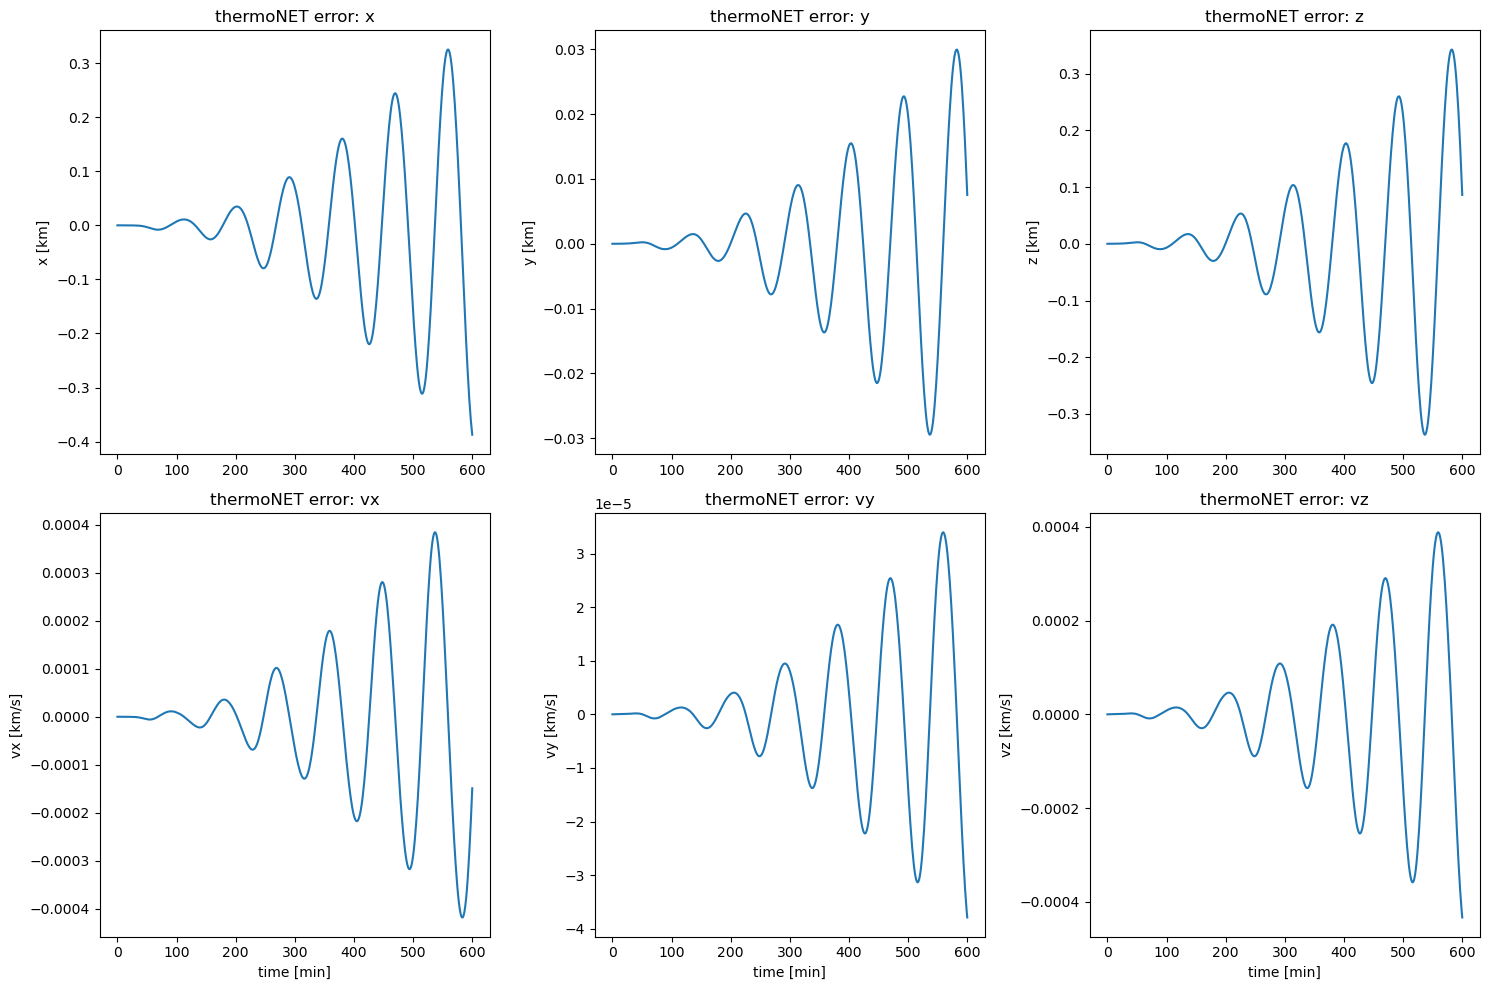

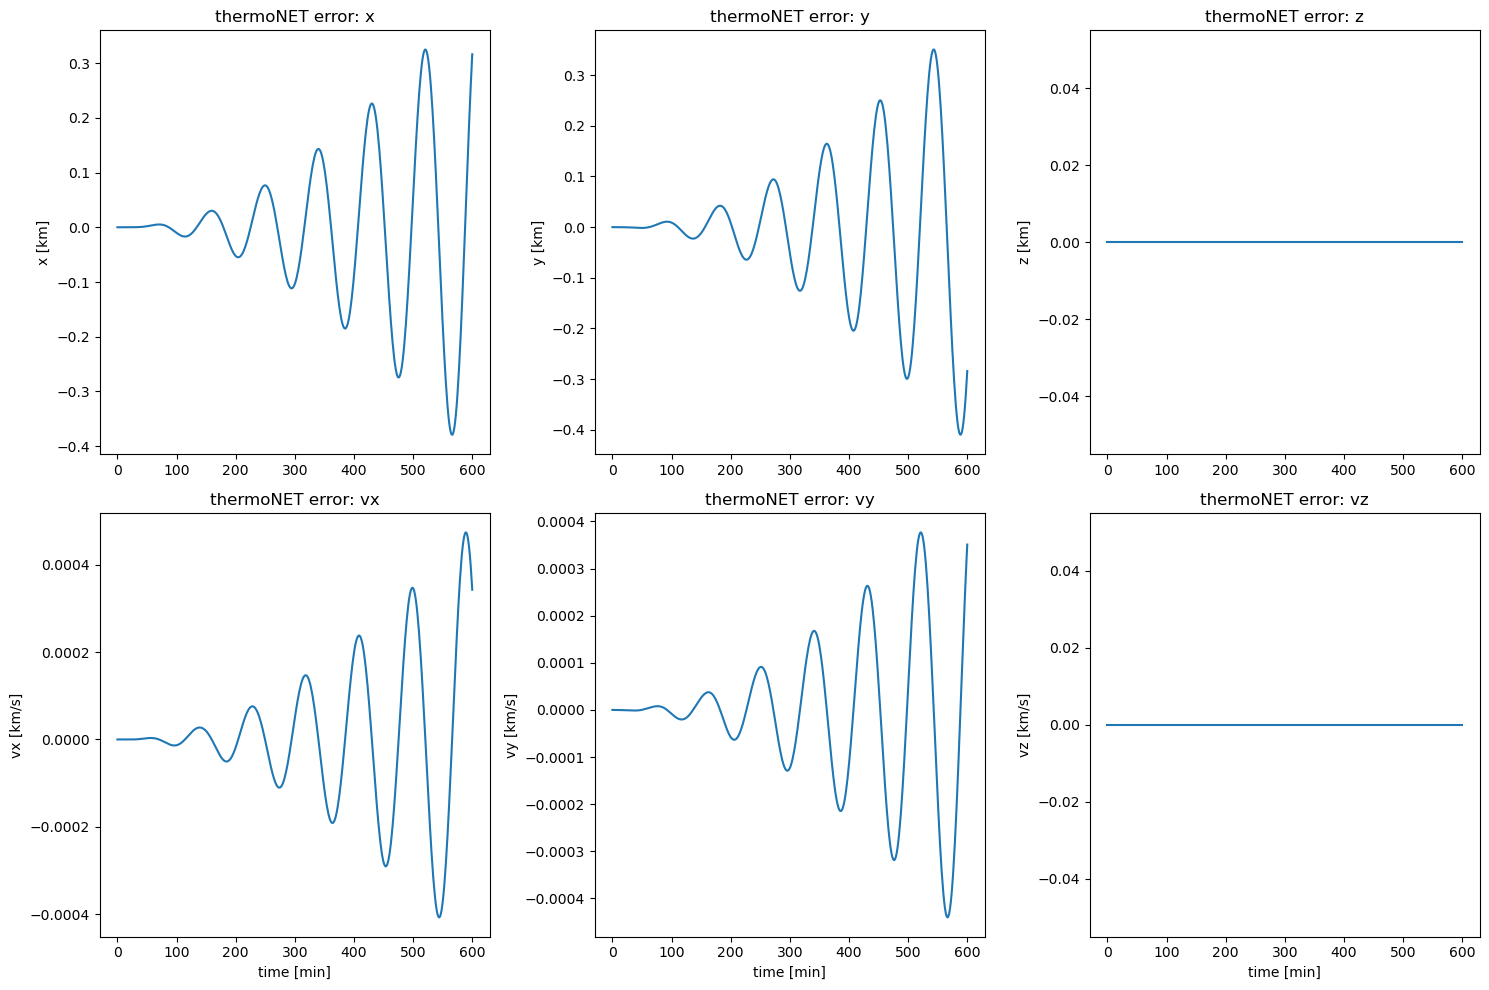

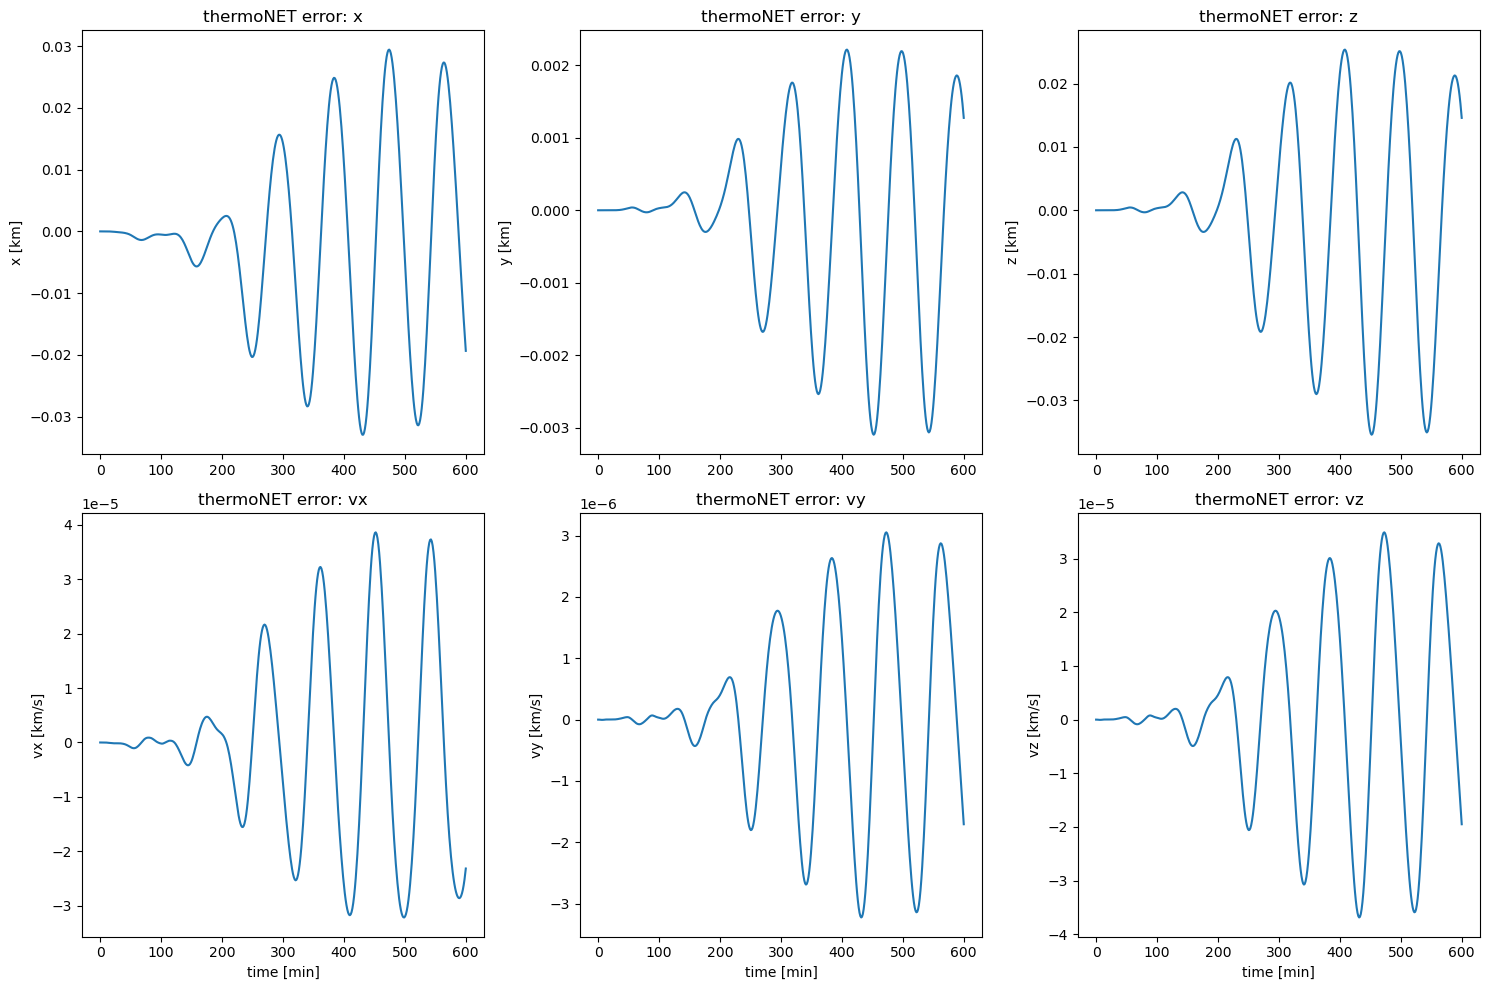

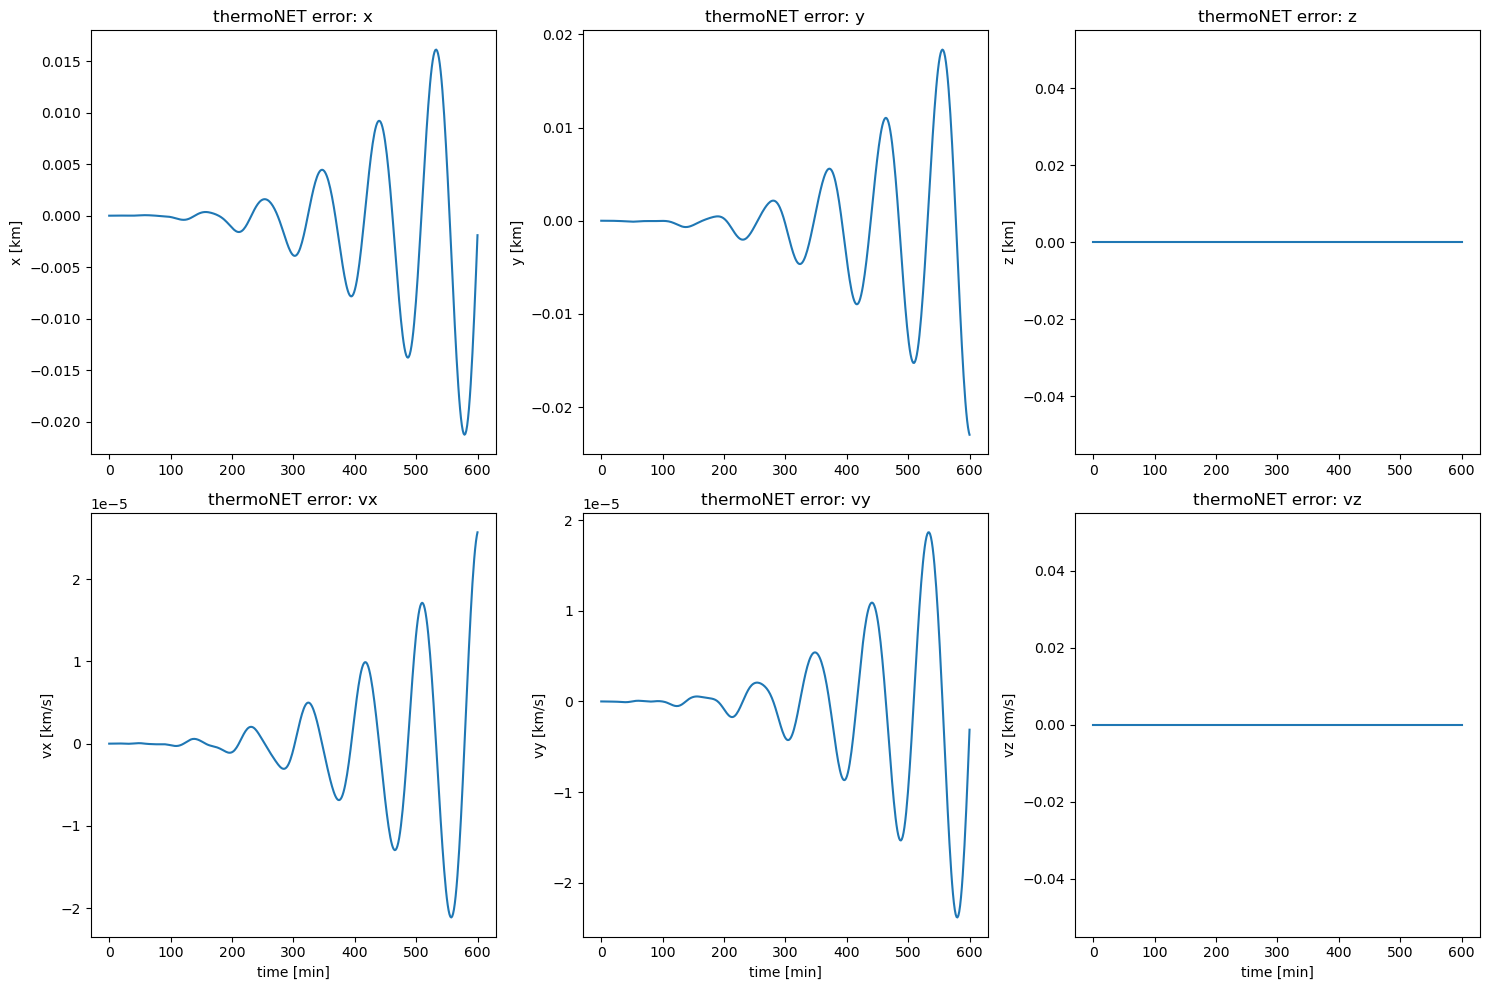

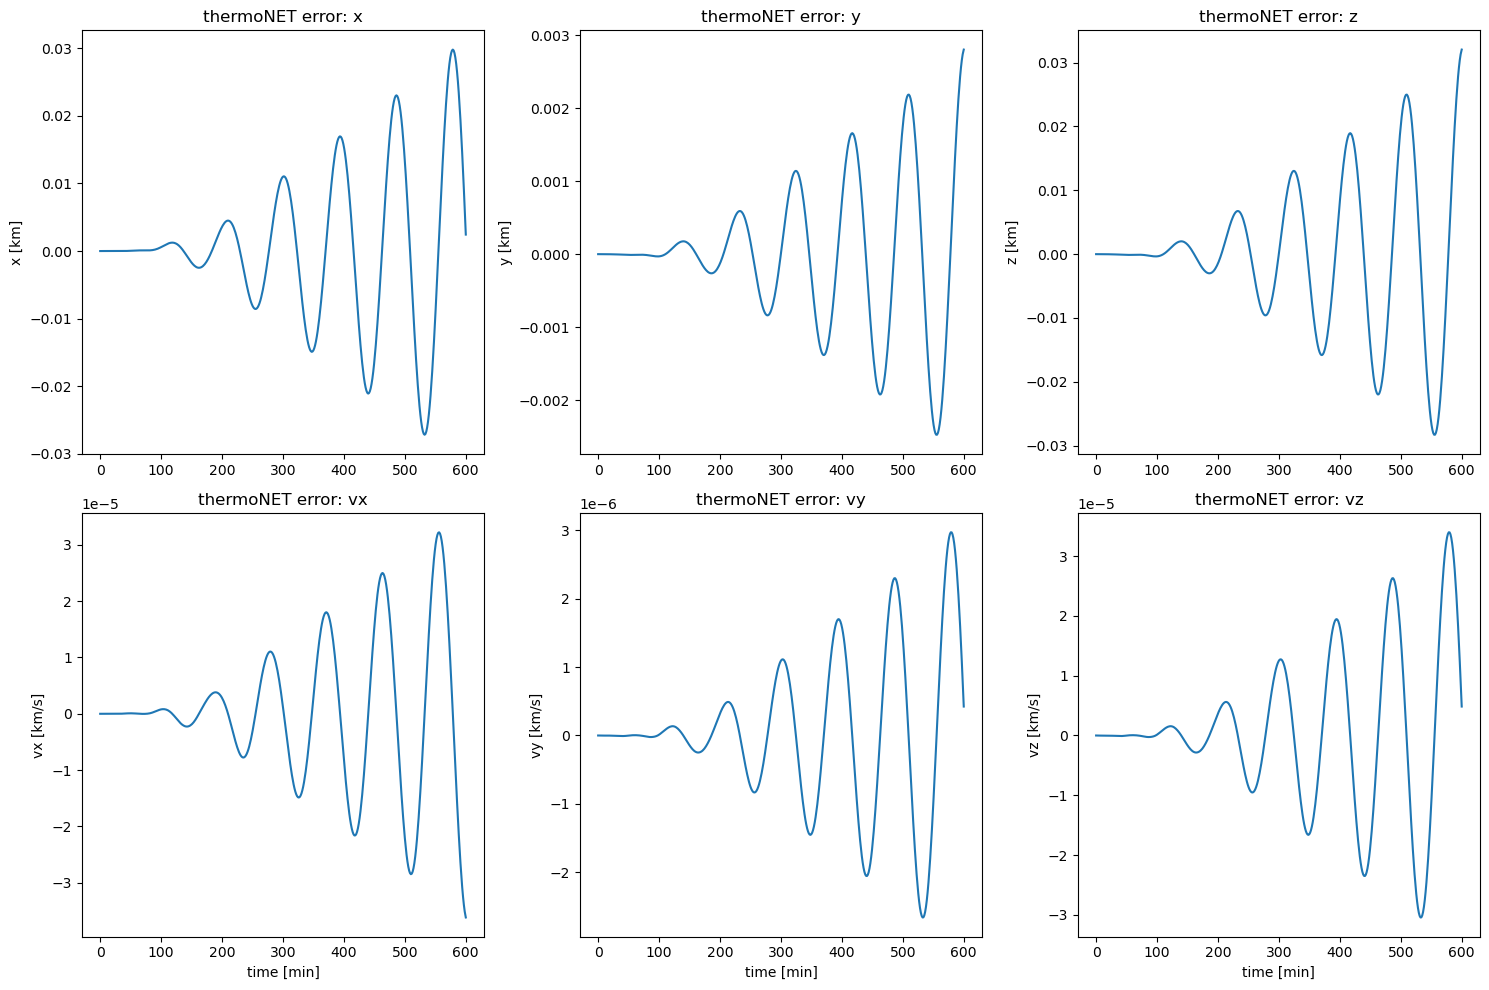

In [48]:
fig_ic, ax_ic = plt.subplots(2, 3,figsize=(10,8))
ax_ic=ax_ic.ravel()
for i, ic in enumerate(initial_states):
    sol = solve_ivp(dxdt, 
                t_span, 
                ic, 
                args=(mu, f107a, f107, ap, bc, date0, omega_e), 
                method='DOP853',
                rtol=1e-13,
                atol=1e-14)
    ta.state[:] = ic
    ta.time=0.
    sol_heyoka_nn=ta.propagate_grid(sol.t)
#    ta_global_fit.state[:] = ic
#    ta_global_fit.time=0.
#    sol_heyoka_fit_global=ta_global_fit.propagate_grid(sol.t)
    #we plot the trajectories, as well as the errors between thermoNET and sol and fit global and sol
    fig, ax = plt.subplots(2, 3,figsize=(15,10))
    ax[0,0].plot(sol.t/60.,(sol.y[0]-sol_heyoka_nn[-1][:,0])/1e3)
    ax[0,0].set_title('thermoNET error: x')
    ax[0,0].set_ylabel('x [km]')
    ax[0,1].plot(sol.t/60.,(sol.y[1]-sol_heyoka_nn[-1][:,1])/1e3)
    ax[0,1].set_title('thermoNET error: y')
    ax[0,1].set_ylabel('y [km]')
    ax[0,2].plot(sol.t/60.,(sol.y[2]-sol_heyoka_nn[-1][:,2])/1e3)
    ax[0,2].set_title('thermoNET error: z')
    ax[0,2].set_ylabel('z [km]')
    ax[1,0].plot(sol.t/60.,(sol.y[3]-sol_heyoka_nn[-1][:,3])/1e3)
    ax[1,0].set_title('thermoNET error: vx')
    ax[1,0].set_xlabel('time [min]')
    ax[1,0].set_ylabel('vx [km/s]')
    ax[1,1].plot(sol.t/60.,(sol.y[4]-sol_heyoka_nn[-1][:,4])/1e3)
    ax[1,1].set_title('thermoNET error: vy')
    ax[1,1].set_xlabel('time [min]')
    ax[1,1].set_ylabel('vy [km/s]')
    ax[1,2].plot(sol.t/60.,(sol.y[5]-sol_heyoka_nn[-1][:,5])/1e3)
    ax[1,2].set_title('thermoNET error: vz')
    ax[1,2].set_xlabel('time [min]')
    ax[1,2].set_ylabel('vz [km/s]')
    fig.tight_layout()

    ax_ic[i].plot(sol.t/60.,np.sqrt(sol.y[0,:]**2+sol.y[1,:]**2+sol.y[2,:]**2)/1e3-r_earth/1e3,label='NRLMSISE-00')
    ax_ic[i].plot(sol.t/60.,np.sqrt(sol_heyoka_nn[-1][:,0]**2+sol_heyoka_nn[-1][:,1]**2+sol_heyoka_nn[-1][:,2]**2)/1e3-r_earth/1e3,label='thermoNET')
#    ax_ic[i].plot(sol.t/60.,np.sqrt(sol_heyoka_fit_global[-1][:,0]**2+sol_heyoka_fit_global[-1][:,1]**2+sol_heyoka_fit_global[-1][:,2]**2)/1e3,label='global fit')
    if i==0 or i==3:
        ax_ic[i].set_ylabel('h [km]')
    if i==1:    
        ax_ic[i].set_title('NRLMSISE-00 vs thermoNET')
        ax_ic[i].legend()
    if i>=3:
        ax_ic[i].set_xlabel('time [min]')
    ax_ic[i].grid()
fig_ic.tight_layout()
